## What
Data analysis and model creation for a US based housing company Surprised Housing.
## Why
The housing company is entering Australian market. They are in the business of buying properties when the price is low and
selling it when the price is high. Our data analysis and model will help the company increase its revenue.

In [1]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

   # Data analysis and cleaning

In [2]:
# load the dataset
df = pd.read_csv("train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

There are 1460 rows with 81 columns. 80 columns if we make the id field the index_column. we observe, there are fields with null values, let us clean the data

In [4]:
#define a method to print null columns with percentage as input parameter.
#The method prints only the fields with that percentage of null values and above.
def print_null_columns(df,per=0):
  for x in df.columns:
    nval=df[x].isnull().sum()
    if nval>0:
      percent=(nval/df[x].isnull().count()*100)
      if(percent>=per):
          print(f'{x} : {percent}% {df[x].dtype}')
print_null_columns(df,30)

Alley : 93.76712328767123% object
FireplaceQu : 47.26027397260274% object
PoolQC : 99.52054794520548% object
Fence : 80.75342465753424% object
MiscFeature : 96.30136986301369% object


In [5]:
# Drop fields with more than 30% missing values along with the id field.
df.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature','Id'],axis=1,inplace=True)

In [6]:
print_null_columns(df)

LotFrontage : 17.73972602739726% float64
MasVnrType : 0.547945205479452% object
MasVnrArea : 0.547945205479452% float64
BsmtQual : 2.5342465753424657% object
BsmtCond : 2.5342465753424657% object
BsmtExposure : 2.6027397260273974% object
BsmtFinType1 : 2.5342465753424657% object
BsmtFinType2 : 2.6027397260273974% object
Electrical : 0.0684931506849315% object
GarageType : 5.5479452054794525% object
GarageYrBlt : 5.5479452054794525% float64
GarageFinish : 5.5479452054794525% object
GarageQual : 5.5479452054794525% object
GarageCond : 5.5479452054794525% object


In [7]:
# let us consider the numeric fields which have null values but below 30%. These are candidates for imputation.
df[['LotFrontage','MasVnrArea','GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


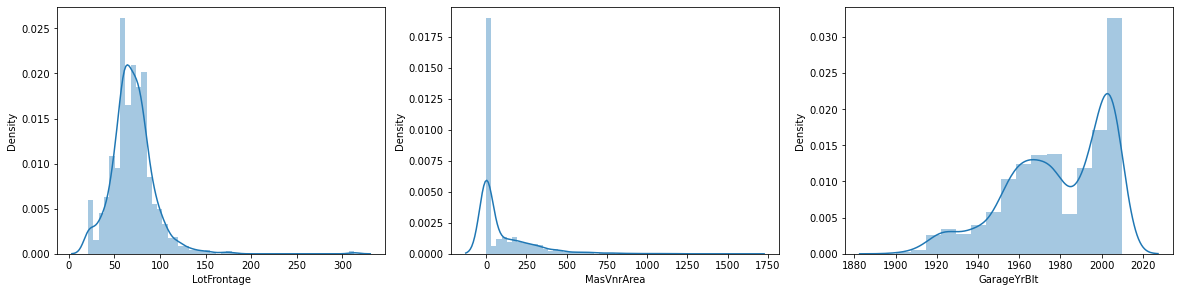

In [8]:
def plotDist(height,width,r,c,data):
    plt.figure(figsize=(height,width))
    for i in range(len(data)):
        plt.subplot(2,3,i+1)
        sns.distplot(df[data[i]])
plotDist(20,10,1,3,['LotFrontage','MasVnrArea','GarageYrBlt'])

In [9]:
 #Impute the data with median.
df['LotFrontage']= df.LotFrontage.fillna(df.LotFrontage.median())
df['MasVnrArea']= df.MasVnrArea.fillna(df.MasVnrArea.median())
df['GarageYrBlt']= df.GarageYrBlt.fillna(df.GarageYrBlt.mean())

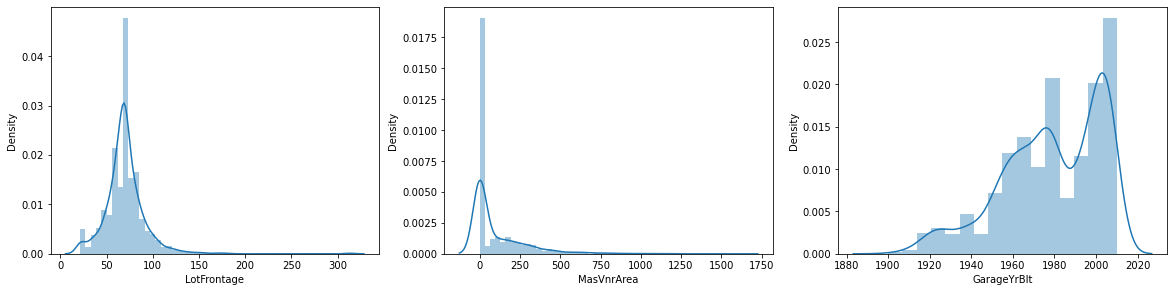

In [10]:
plotDist(20,10,1,3,['LotFrontage','MasVnrArea','GarageYrBlt'])

In [11]:
#Imputation of median, did not have any significant impact to stats as seen in the above visualization.

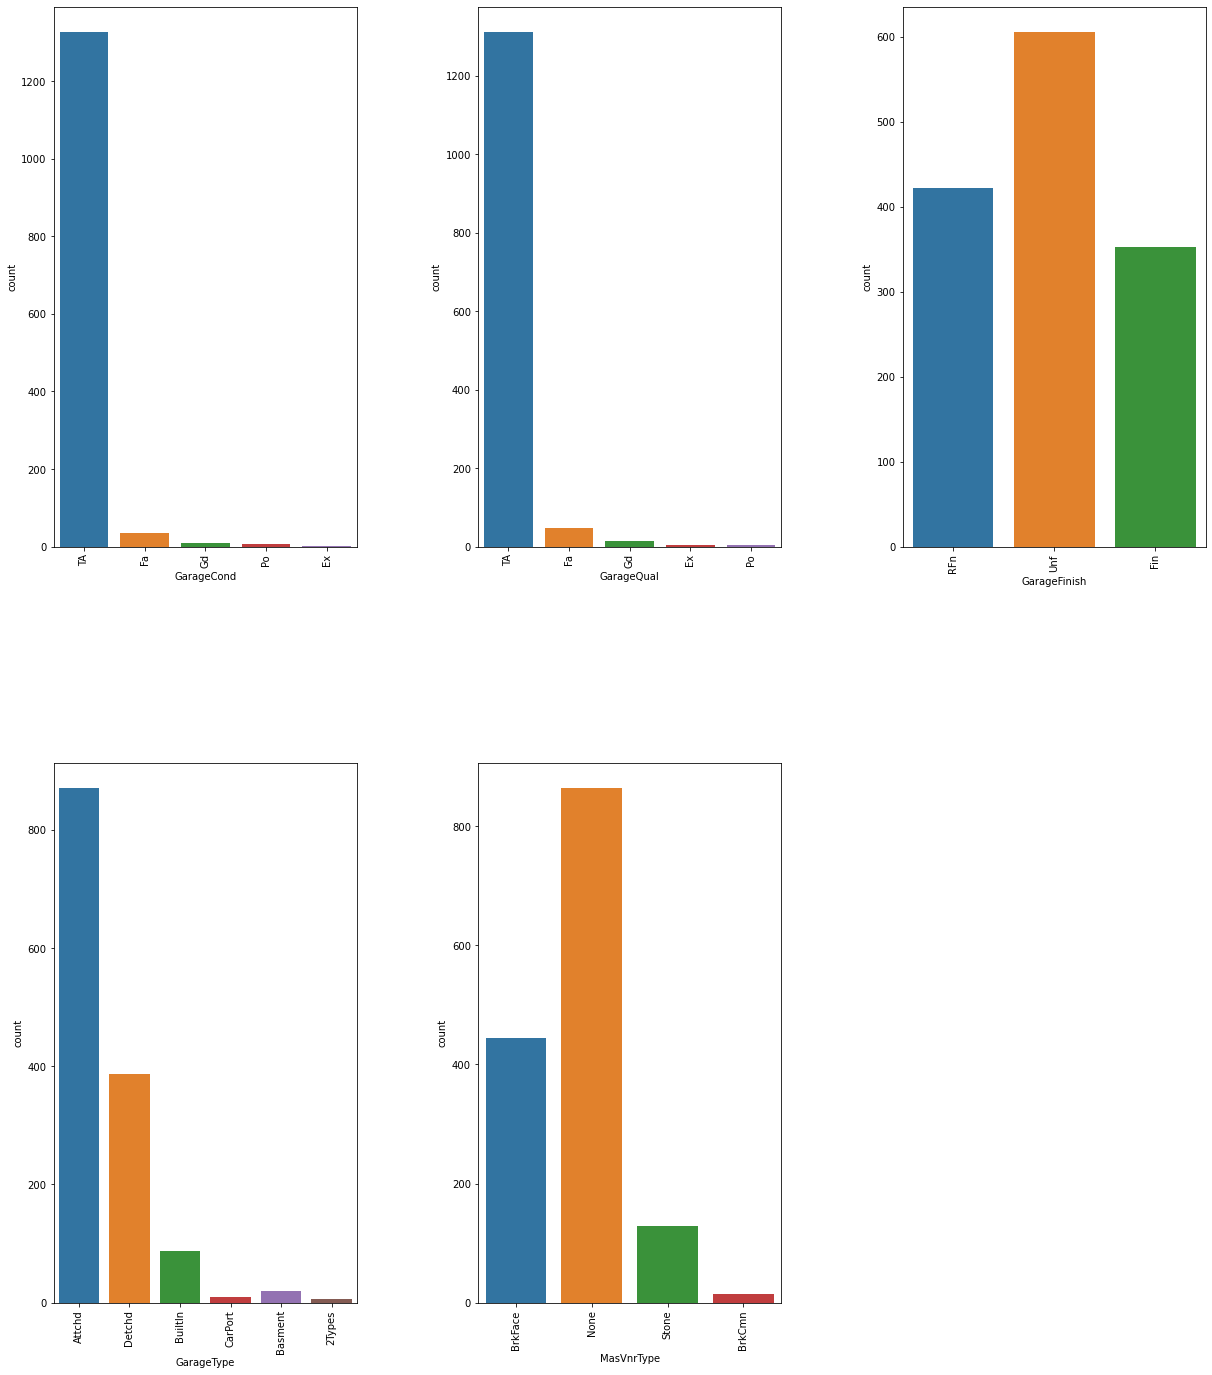

In [12]:
#Visualise the categorical variables wih missing values by using a count plot. This allows us to choose 
#category for imputation and also highlights any skew in data. Randomly we shall consider few fields at a time.
#Inferences if any will be noted in comments.

def plotCount(height,width,r,c,data):
    plt.figure(figsize=(height,width))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
    for i in range(len(data)):
        plt.subplot(r,c,i+1)
        sns.countplot(x = data[i], data = df)
        plt.xticks(rotation=90)
    plt.show()    
plotCount(20,20,2,3,['GarageCond','GarageQual','GarageFinish','GarageType','MasVnrType'])

In [13]:
# drop the fields which are highly skewed.
df.drop(['GarageCond','GarageQual'],axis=1,inplace=True)

# Handle null values for other fields
# The remaining garage fields have around 5.5% missing data. This we found using the "print_null_columns(df)" method
# in line number 6 of this notebook. Impute them with data as No Garage.
# We are getting No Garage from data definition file provided by business.
df['GarageType'] = df['GarageType'].fillna('No Garage')
df['GarageFinish'] = df['GarageFinish'].fillna('No Garage')
# impute none to MasVnrType
df['MasVnrType'] = df['MasVnrType'].fillna('None')
print_null_columns(df)

BsmtQual : 2.5342465753424657% object
BsmtCond : 2.5342465753424657% object
BsmtExposure : 2.6027397260273974% object
BsmtFinType1 : 2.5342465753424657% object
BsmtFinType2 : 2.6027397260273974% object
Electrical : 0.0684931506849315% object


Observations:
1. The Garage condition and garage quality fields are heavily skewed towards Typical/Average.
2. Majority of properties have unfinished garage finish.
3. Majority of properties have an attached garage type.
4. Majority of properties have none as Masonry veneer type.

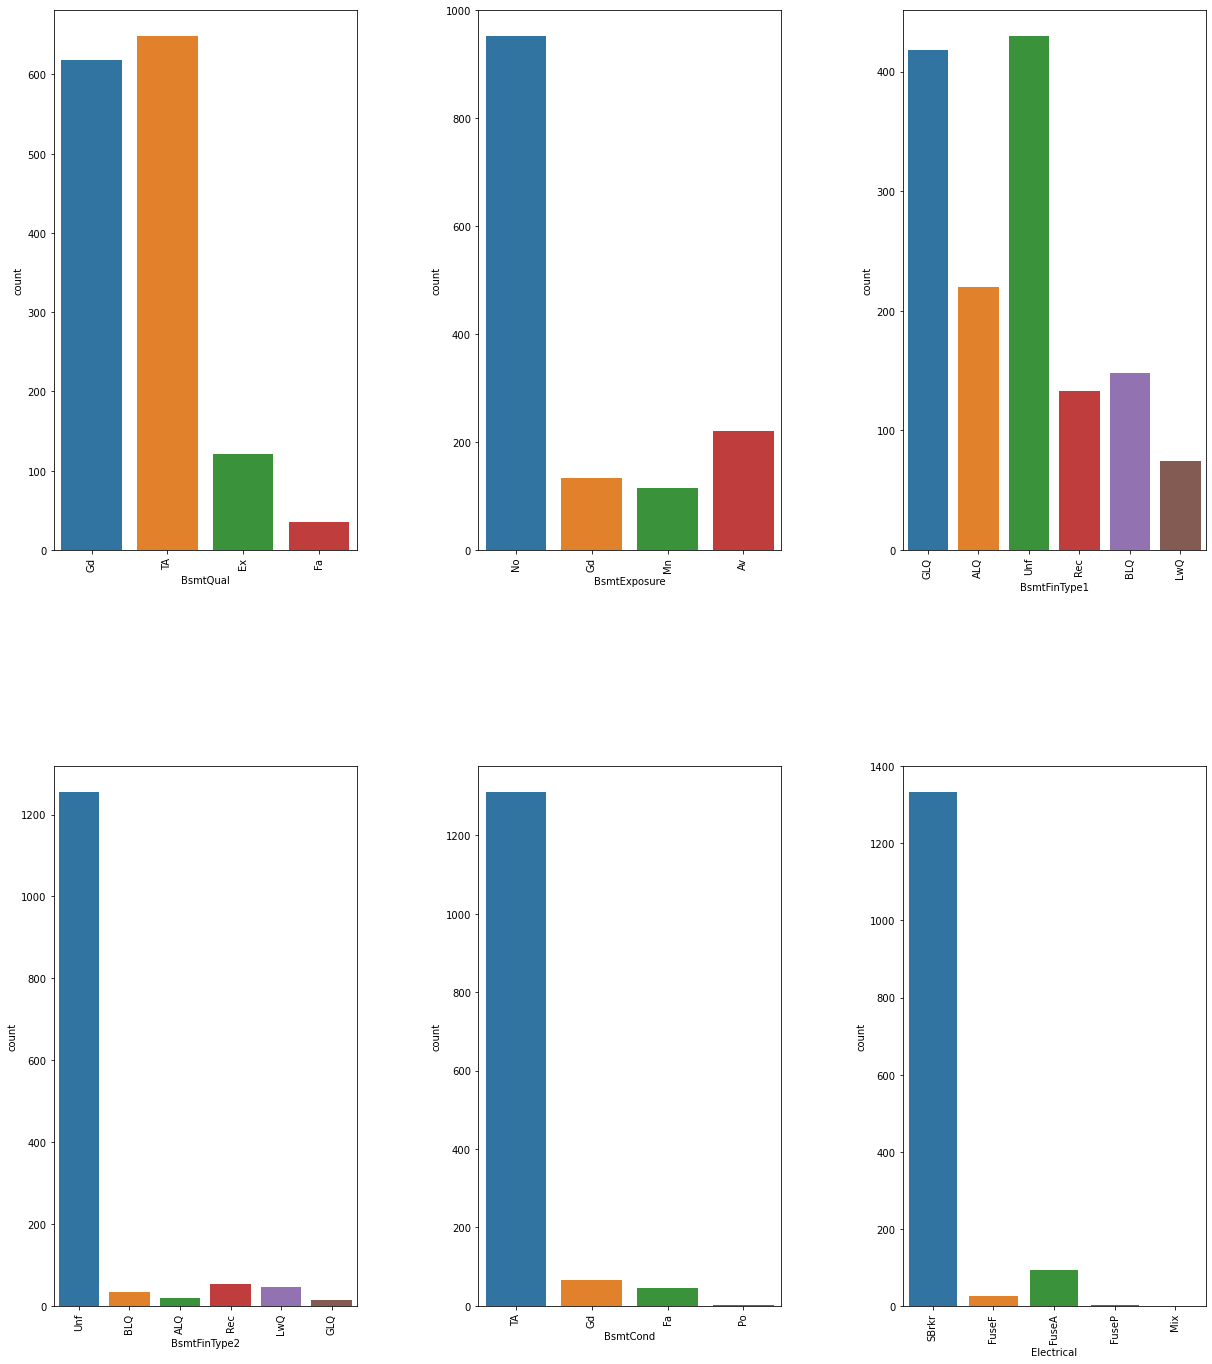

In [14]:
plotCount(20,20,2,3,['BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtCond','Electrical'])

In [15]:
# Handle the null values for the basement fields.
df['BsmtQual'] = df['BsmtQual'].fillna('No Basement')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No Basement')
df['BsmtCond']=df['BsmtCond'].fillna('NA')
df['BsmtFinType1']=df['BsmtFinType1'].fillna('NA')
df['Electrical'] = df['Electrical'].fillna('SBrkr') #it looks skewed, we will check later and drop
#drop BsmtFinType2 as it is definitely skewed
df.drop('BsmtFinType2',axis=1,inplace=True)
print_null_columns(df)

Observations:
1. The basement finish type 2 is heavily skewed towards unfinished
2. Majority of properties have typical/average basement quality
3. Majority of properties have an no exposure of basement
4. Majority of properties have unfinished basement
5. The basement condition is typical/average for majority of the properties
6. Standard Circuit Breakers & Romex electrical system is present in majority of properties 

In [16]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [17]:
# The target variable is SalePrice
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

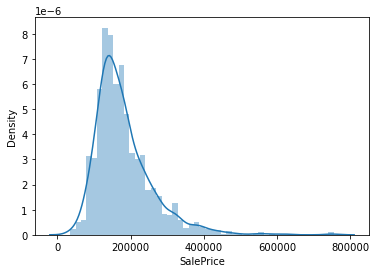

In [18]:
sns.distplot(df['SalePrice'])

In [19]:
df['SalePrice'].skew()

1.8828757597682129

In [20]:
# Apply log transformation to form a normal distribution
df['SalePrice']=np.log(df.SalePrice)

In [21]:
df['SalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

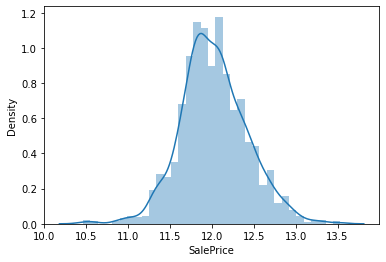

In [22]:
sns.distplot(df['SalePrice'])

In [23]:
df['SalePrice'].skew()

0.12133506220520406

Dependent variable SalePrice is now normally distributed.

In [24]:
catvars=['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
         'Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
         'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
         'Heating', 'HeatingQC','CentralAir', 'Electrical', 'KitchenQual','Functional', 'GarageType', 'GarageFinish',
         'PavedDrive','SaleType','SaleCondition'
         ]

In [25]:
# lets mark the catvars as category types in dataframe
for col in catvars:
    df[col]=df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   LotShape       1460 non-null   category
 6   LandContour    1460 non-null   category
 7   Utilities      1460 non-null   category
 8   LotConfig      1460 non-null   category
 9   LandSlope      1460 non-null   category
 10  Neighborhood   1460 non-null   category
 11  Condition1     1460 non-null   category
 12  Condition2     1460 non-null   category
 13  BldgType       1460 non-null   category
 14  HouseStyle     1460 non-null   category
 15  OverallQual    1460 non-null   category
 16  OverallCond    1460 non-null   category
 17  YearBuilt      1460 non-null   in

In [26]:
# Handle the remaining skewed data by dropping them.
for c in catvars:
        print(df[c].value_counts(normalize=True))

20     0.367123
60     0.204795
50     0.098630
120    0.059589
30     0.047260
160    0.043151
70     0.041096
80     0.039726
90     0.035616
190    0.020548
85     0.013699
75     0.010959
45     0.008219
180    0.006849
40     0.002740
Name: MSSubClass, dtype: float64
RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64
Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64
Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64
Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64
AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64
Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64
Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64
NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397


In [27]:
skewedCatVars=['Street','LandContour','Utilities','LandSlope','Condition1','Condition2','BldgType','RoofMatl',
        'ExterCond','BsmtCond','Heating','CentralAir','Electrical','Functional',
        'GarageType','PavedDrive','SaleType','SaleCondition']
df.drop(skewedCatVars,axis=1,inplace=True)

In [28]:
# MSSubClass, OverallQual and OverallCond are categorical vars stored as numeric. Use map function to change it.
df['MSSubClass']=df['MSSubClass'].map({
        20:'1-STORY 1946 & NEWER ALL STYLES',
        30:'1-STORY 1945 & OLDER',
        40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
       120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       150:'1-1/2 STORY PUD - ALL AGES',
       160:'2-STORY PUD - 1946 & NEWER',
       180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
       190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'})

df['OverallQual']=df['OverallQual'].map({ 
       10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})
df['OverallCond']=df['OverallCond'].map({ 
       10:'Very Excellent',
       9:'Excellent',
       8:'Very Good',
       7:'Good',
       6:'Above Average',
       5:'Average',
       4:'Below Average',
       3:'Fair',
       2:'Poor',
       1:'Very Poor'})

In [29]:
# clean the numerical fields. 
# Drop the following columns that have more than 90% values associated to a specific value
def getNumericFieldsWithSkew():
    cols = []    
    for col in (df.select_dtypes(include=[ 'int64', 'float'])):
        if(df[col].value_counts().max() >= (0.9 * df.shape[0])):
            cols.append(col)
    return cols

colsToBeRemoved = getNumericFieldsWithSkew()
df.drop(colsToBeRemoved, axis = 1, inplace = True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
0,2-STORY 1946 & NEWER,RL,65.0,8450,Reg,Inside,CollgCr,2Story,Good,Average,...,2003.0,RFn,2,548,0,61,0,2,2008,12.247694
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Reg,FR2,Veenker,1Story,Above Average,Very Good,...,1976.0,RFn,2,460,298,0,0,5,2007,12.109011
2,2-STORY 1946 & NEWER,RL,68.0,11250,IR1,Inside,CollgCr,2Story,Good,Average,...,2001.0,RFn,2,608,0,42,0,9,2008,12.317167
3,2-STORY 1945 & OLDER,RL,60.0,9550,IR1,Corner,Crawfor,2Story,Good,Average,...,1998.0,Unf,3,642,0,35,272,2,2006,11.849398
4,2-STORY 1946 & NEWER,RL,84.0,14260,IR1,FR2,NoRidge,2Story,Very Good,Average,...,2000.0,RFn,3,836,192,84,0,12,2008,12.429216


# Exploratory data analysis

Analysis of remaining categorical variables. We shall consider few at a time randomly

In [30]:
set1 = set(catvars)
set2 = set(skewedCatVars)
catvars = list(set1 - set2)

In [31]:
catvars

['MSSubClass',
 'HouseStyle',
 'Foundation',
 'Exterior1st',
 'LotShape',
 'RoofStyle',
 'BsmtQual',
 'OverallCond',
 'ExterQual',
 'KitchenQual',
 'MSZoning',
 'GarageFinish',
 'BsmtFinType1',
 'HeatingQC',
 'LotConfig',
 'MasVnrType',
 'Neighborhood',
 'OverallQual',
 'BsmtExposure',
 'Exterior2nd']

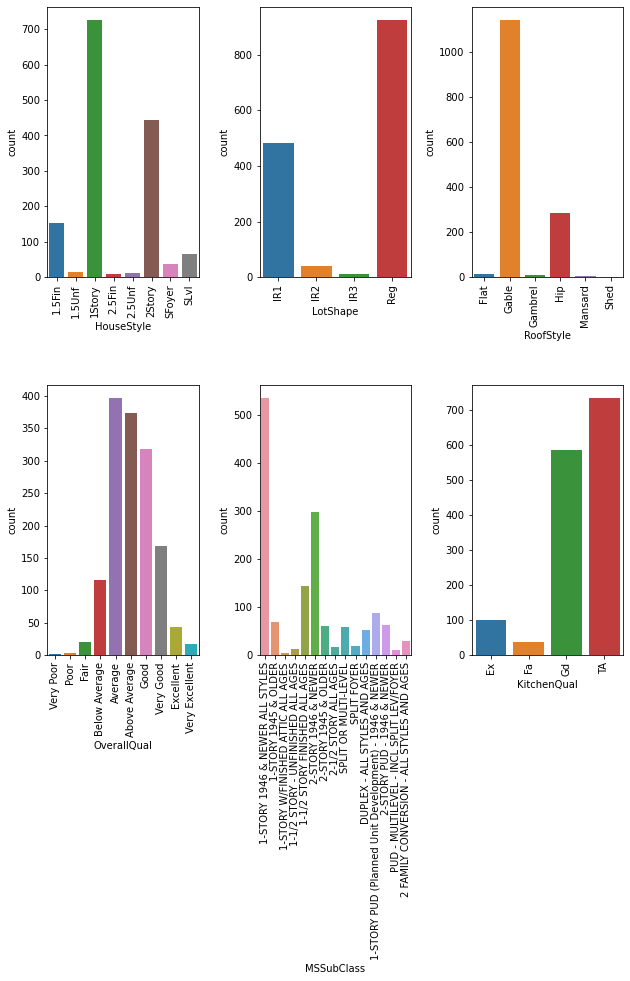

In [32]:
plotCount(10,10,2,3,['HouseStyle',
 'LotShape',
 'RoofStyle', 
 'OverallQual',
 'MSSubClass',
 'KitchenQual'])

Observation:
1. 1 and 2 story properties are highest present in the data.
2. Properties with regular shape are highest present in the data.
3. Properties with Gable roof style are highest present in the data.
4. Properties have an overall quality between average and good.
5. 1-STORY 1946 & NEWER ALL STYLES and 2-STORY 1946 & NEWER are highest category present for Subclass of properties in data.
6. Kitchen quality ranges between typical average to good.

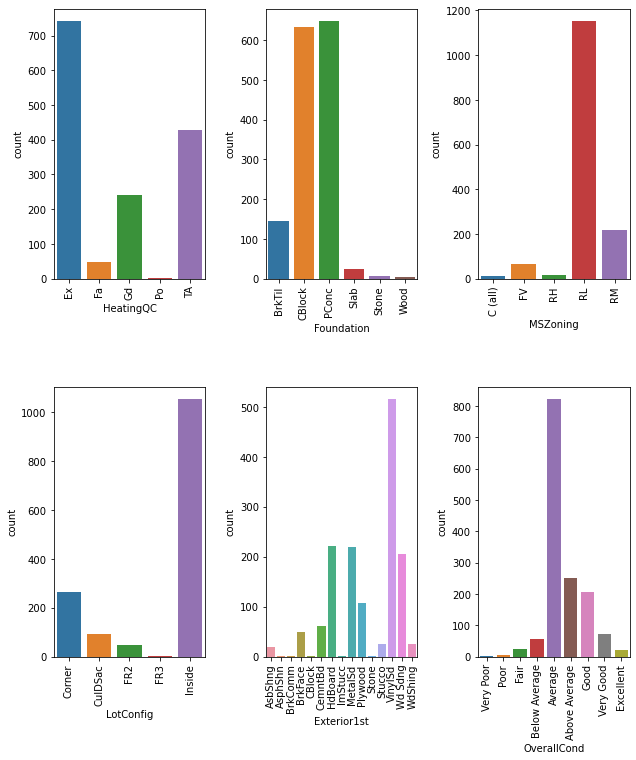

In [33]:
plotCount(10,10,2,3,['HeatingQC',
 'Foundation',
 'MSZoning',
 'LotConfig',
 'Exterior1st',
 'OverallCond'])

Observation
1. Heating quality and condition were excellent.
2. Majority of properties have foundation types as Cinder block and Poured Contrete.
3. Majority of properties fall under regular low density zoning classification.
4. Majority of properties have Inside lot.
5. Vinyl and wood siding were highest used for exterier covering.
6. Overall condition of the properties was average.

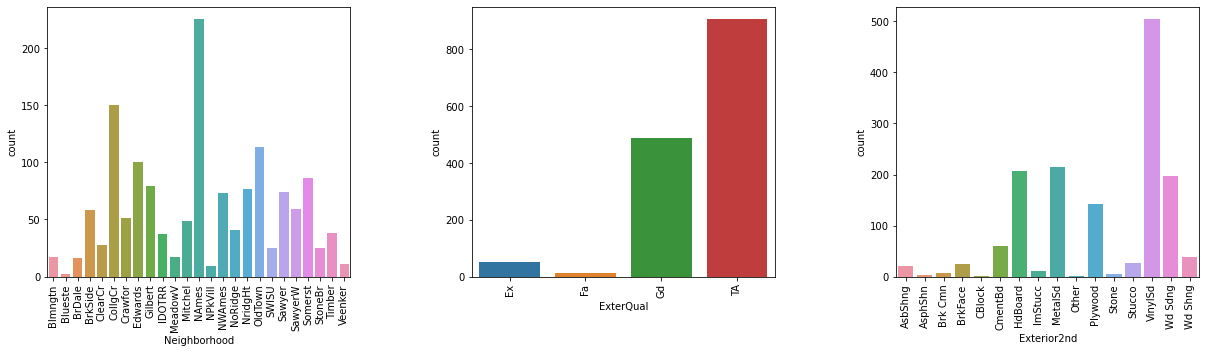

In [34]:
plotCount(20,10,2,3,['Neighborhood',
 'ExterQual',
 'Exterior2nd'])

Observation
1. Majority of properties were from North Ames area of the city.
2. Majority of properties have an average exterier material quality.
3. Vinyl siding were highest used for exterier covering.

In [35]:
catvars = df.select_dtypes(include=['category'])
catvars.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual',
       'GarageFinish'],
      dtype='object')

BiVariate analysis

In [36]:
def biVariateAnalysis(height, width,r,c,x,y,data=df):   
    plt.figure(figsize=(height,width)) 
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
    for i in range(len(x)):
        plt.subplot(r,c,i+1)        
        sns.boxplot(x = x[i],y=y, data = data)
        plt.xticks(rotation=90)
        
    plt.show()

In [37]:
catvars

,MSSubClass,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,GarageFinish
0,2-STORY 1946 & NEWER,RL,Reg,Inside,CollgCr,2Story,Good,Average,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,Gd,RFn
1,1-STORY 1946 & NEWER ALL STYLES,RL,Reg,FR2,Veenker,1Story,Above Average,Very Good,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,TA,RFn
2,2-STORY 1946 & NEWER,RL,IR1,Inside,CollgCr,2Story,Good,Average,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,Gd,RFn
3,2-STORY 1945 & OLDER,RL,IR1,Corner,Crawfor,2Story,Good,Average,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,Gd,Unf
4,2-STORY 1946 & NEWER,RL,IR1,FR2,NoRidge,2Story,Very Good,Average,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,Gd,RFn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2-STORY 1946 & NEWER,RL,Reg,Inside,Gilbert,2Story,Above Average,Average,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,TA,RFn
1456,1-STORY 1946 & NEWER ALL STYLES,RL,Reg,Inside,NWAmes,1Story,Above Average,Above Average,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,TA,Unf
1457,2-STORY 1945 & OLDER,RL,Reg,Inside,Crawfor,2Story,Good,Excellent,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,Gd,RFn
1458,1-STORY 1946 & NEWER ALL STYLES,RL,Reg,Inside,NAmes,1Story,Average,Above Average,Hip,MetalSd,MetalSd,None,TA,CBlock,TA,Mn,GLQ,Gd,Gd,Unf


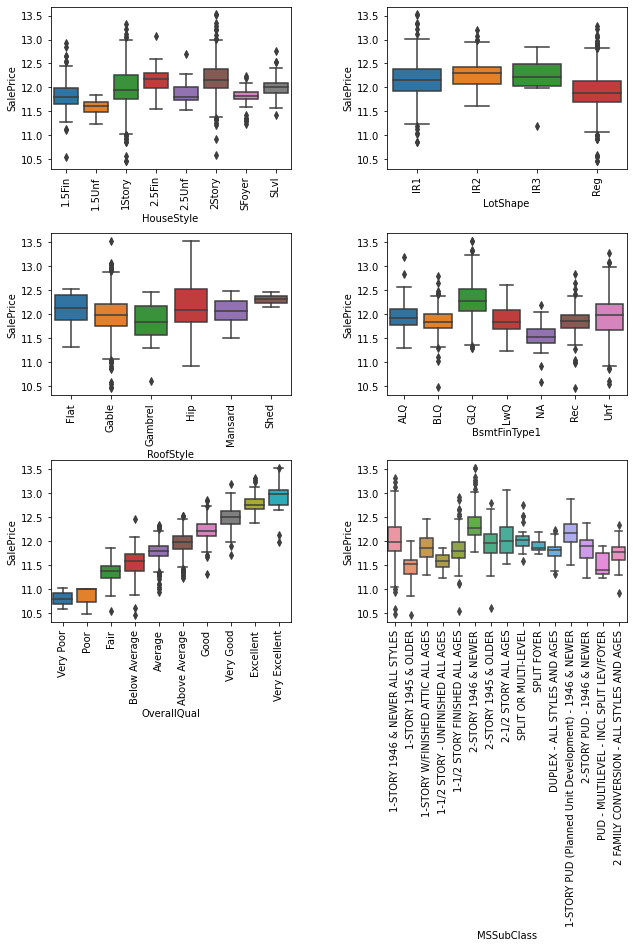

In [38]:
biVariateAnalysis(10,20,6,2,['HouseStyle',
 'LotShape',
 'RoofStyle',
 'BsmtFinType1',
 'OverallQual',
 'MSSubClass'],'SalePrice')

Observation
1. Properties with 2 and 2.5 stories and finished have the highest median sale price.
2. Regular lot shape sold more but have lower median sale price
3. Flat and shed roof style properties have higher median sale price. 
4. Good living quarters have higher median sale price
5. OverAll quality is directly proportional to sale price. Sale price increases as quality improves from very poor to very excellent.
6. 2-STORY 1946 & NEWER sub class properties were sold for higher prices.

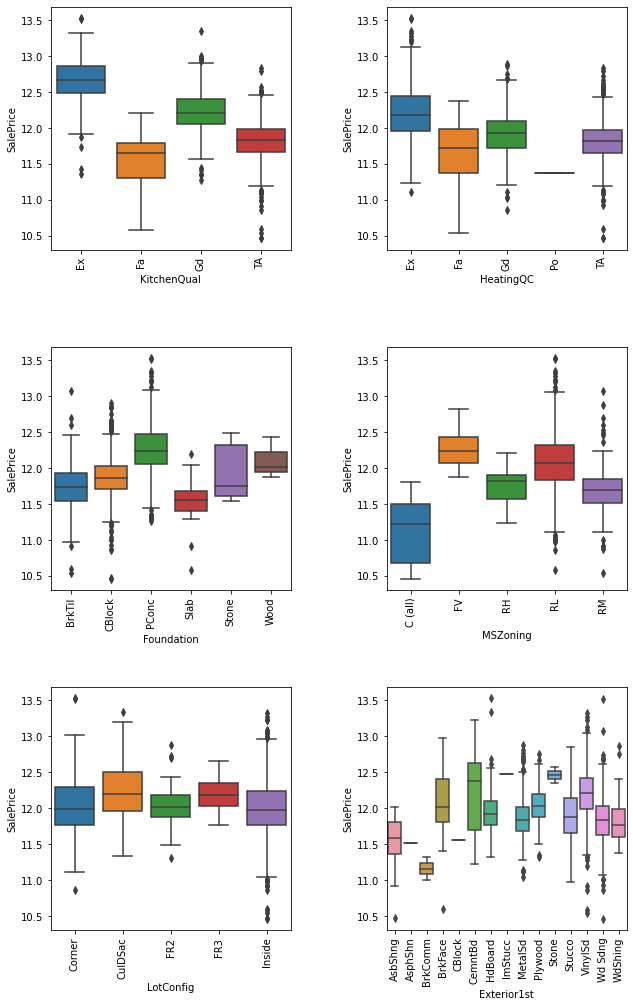

In [39]:
biVariateAnalysis(10,30,6,2,[ 'KitchenQual',
 'HeatingQC',
 'Foundation',
 'MSZoning',
 'LotConfig',
 'Exterior1st'],'SalePrice')

Observations:
1. Kitchen quality is directly proportional to sale price.
2. Excellent kitchen quality increases the price of the property
3. Excellent heating quality and condition increases the price of the property
4. Poured concrete foundation increases the price of the property
5. Floating Village Residential properties have higher price
6. Cul-de-sac and properties with frontage on 3 sides have higher price
7. Cement board and Stone exterior properties have higher price.

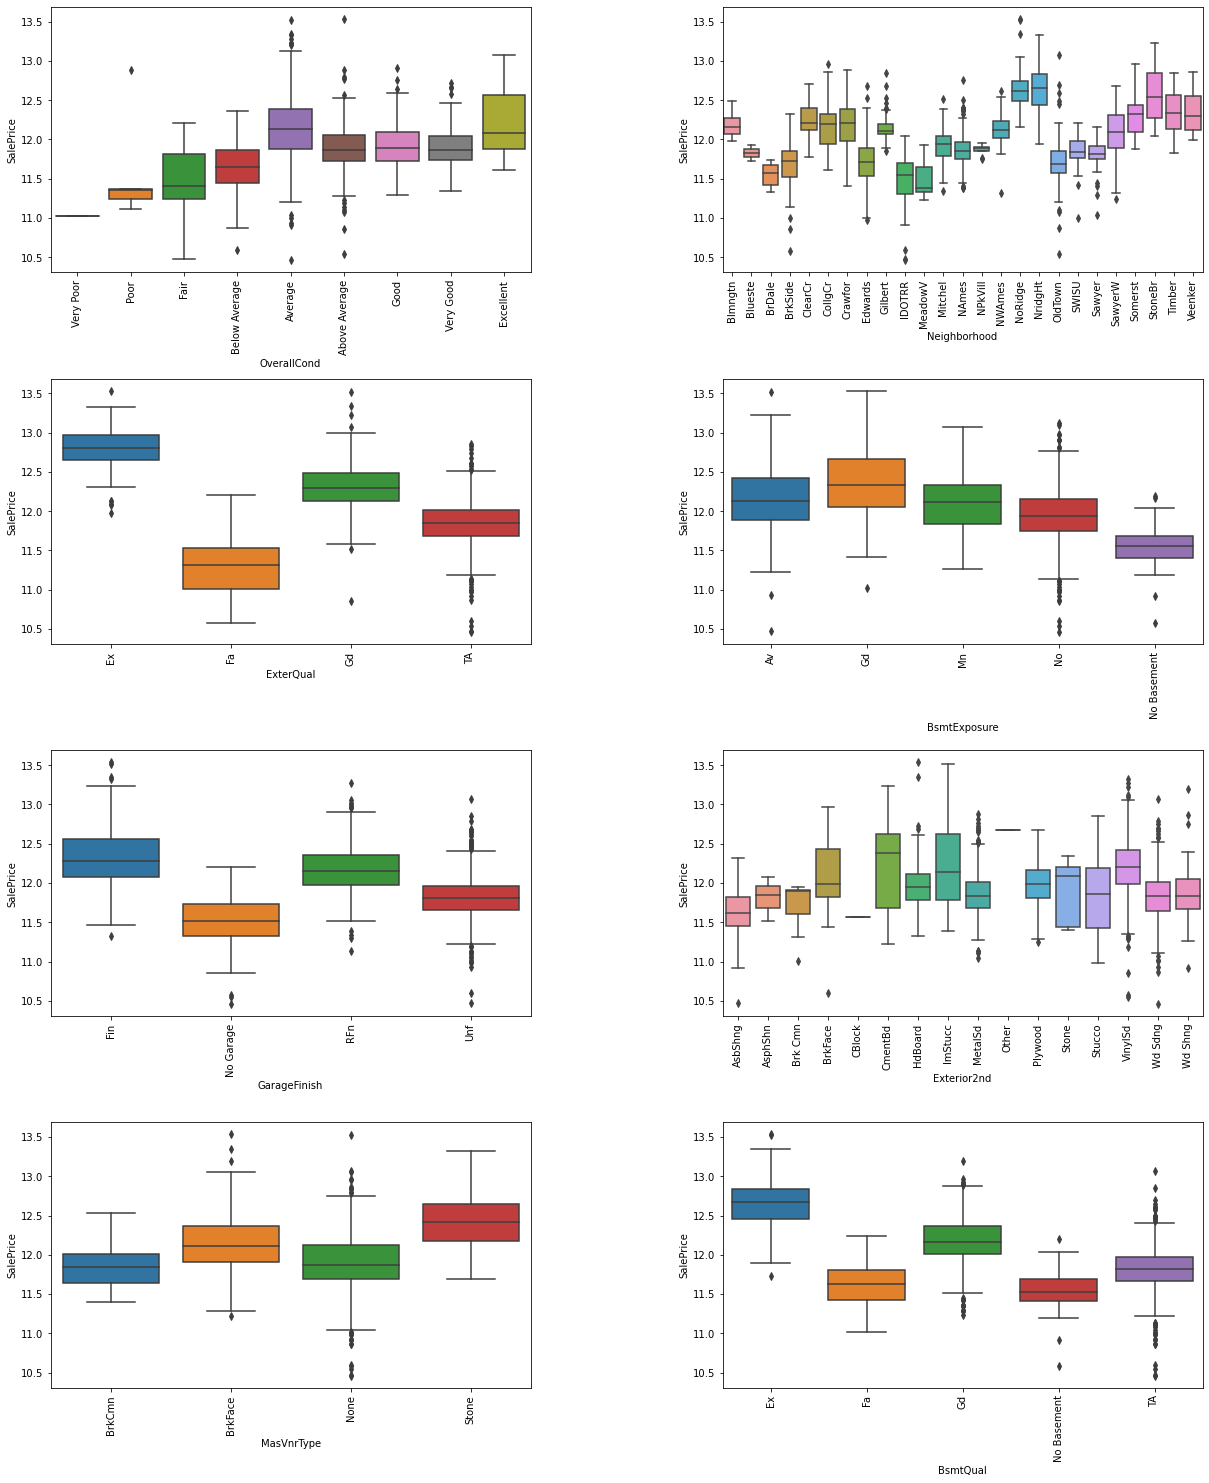

In [40]:
biVariateAnalysis(20,50,9,2,[ 'OverallCond',
 'Neighborhood',
 'ExterQual',
 'BsmtExposure',
 'GarageFinish',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual'],'SalePrice')

Observations:
1. Properties with overall condition being average and excellent have higher price.
2. Properties in Northridge and Northridge Heights have higher price.
3. External quality of the property is directly proportional with sale price increasing as quality improves
4. Basement exposure of the property is directly proportional with sale price increasing as exposure improves
5. Finished garages increase sale price of the property. Sale price of properties without garage was the lowest
6. Cement board exterier covering increases the sale price marginally
7. Stone masonry veneer type increases the sale price of the property
8. Basement quality is directly proportional to sale price

In [41]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
0,2-STORY 1946 & NEWER,RL,65.0,8450,Reg,Inside,CollgCr,2Story,Good,Average,...,2003.0,RFn,2,548,0,61,0,2,2008,12.247694
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Reg,FR2,Veenker,1Story,Above Average,Very Good,...,1976.0,RFn,2,460,298,0,0,5,2007,12.109011
2,2-STORY 1946 & NEWER,RL,68.0,11250,IR1,Inside,CollgCr,2Story,Good,Average,...,2001.0,RFn,2,608,0,42,0,9,2008,12.317167
3,2-STORY 1945 & OLDER,RL,60.0,9550,IR1,Corner,Crawfor,2Story,Good,Average,...,1998.0,Unf,3,642,0,35,272,2,2006,11.849398
4,2-STORY 1946 & NEWER,RL,84.0,14260,IR1,FR2,NoRidge,2Story,Very Good,Average,...,2000.0,RFn,3,836,192,84,0,12,2008,12.429216


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   LotShape       1460 non-null   category
 5   LotConfig      1460 non-null   category
 6   Neighborhood   1460 non-null   category
 7   HouseStyle     1460 non-null   category
 8   OverallQual    1460 non-null   category
 9   OverallCond    1460 non-null   category
 10  YearBuilt      1460 non-null   int64   
 11  YearRemodAdd   1460 non-null   int64   
 12  RoofStyle      1460 non-null   category
 13  Exterior1st    1460 non-null   category
 14  Exterior2nd    1460 non-null   category
 15  MasVnrType     1460 non-null   category
 16  MasVnrArea     1460 non-null   float64 
 17  ExterQual      1460 non-null   ca

In [43]:
# derive few date columns
df['age_of_property']=df['YrSold']-df['YearBuilt']
df['age_of_garage'] = df['YrSold'] - df['GarageYrBlt']
df['age_after_last_remodel'] = df['YrSold'] - df['YearRemodAdd']
# MoSold and YrSold have very less unique values. Treat them as categories.
df['YrSold']=df['YrSold'].astype('category')
df['MoSold']=df['MoSold'].astype('category')

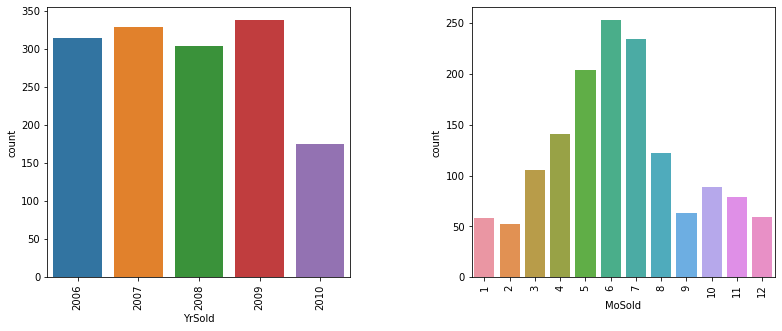

In [44]:
plotCount(20,10,2,3,['YrSold',
 'MoSold'])

Observation
1. 2009 saw higher sales
2. Sales start to rise from March until June and starts to decrease thereafter.

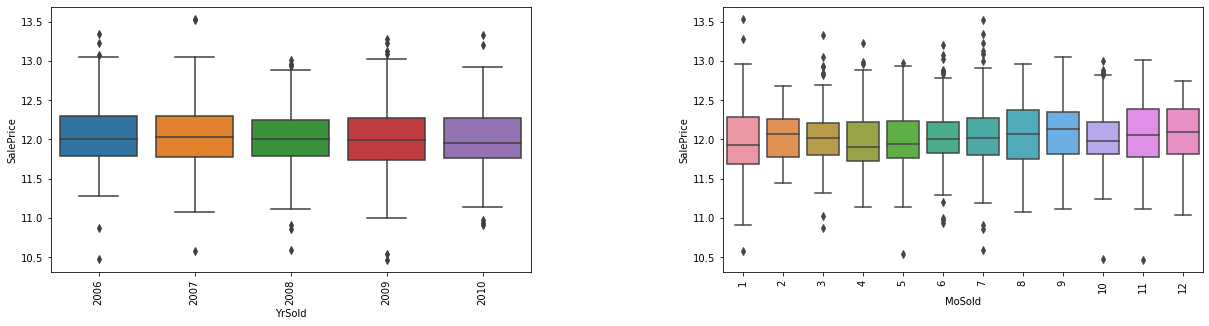

In [45]:
biVariateAnalysis(20,50,9,2,[ 'YrSold',
 'MoSold'],'SalePrice')

Observation
1. year of sale has almost no impact on sale prices
2. No clear pattern seen for month sold vs sale price

In [46]:
df.drop(['YearBuilt','GarageYrBlt','YearRemodAdd'],axis=1,inplace=True)

In [47]:
catvars=df.select_dtypes(include=['category'])
catvars.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual',
       'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual',
       'GarageFinish', 'MoSold', 'YrSold'],
      dtype='object')

In [48]:
numvars = df.select_dtypes(include=['int64','float64']) #all numerical variables
numvars.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'SalePrice', 'age_of_property', 'age_of_garage',
       'age_after_last_remodel'],
      dtype='object')

<Figure size 720x360 with 0 Axes>

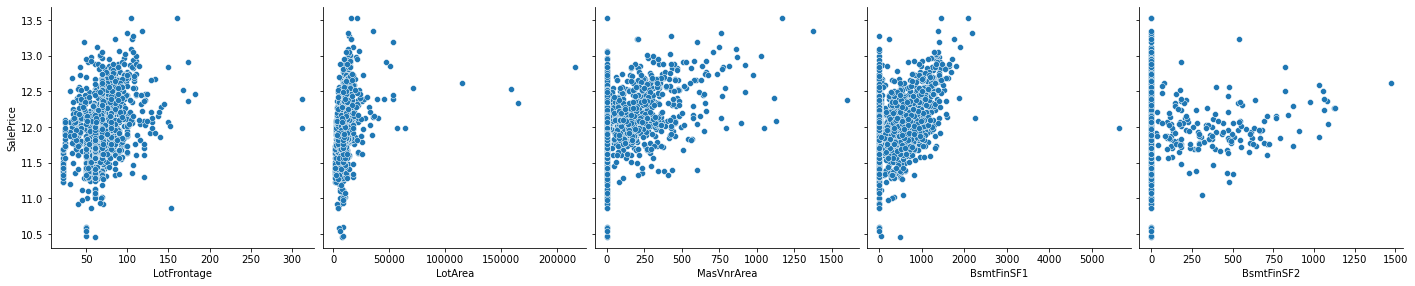

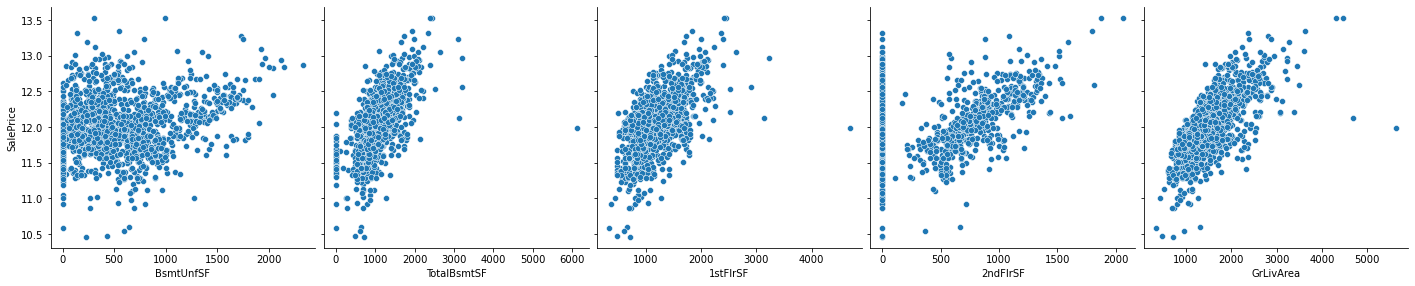

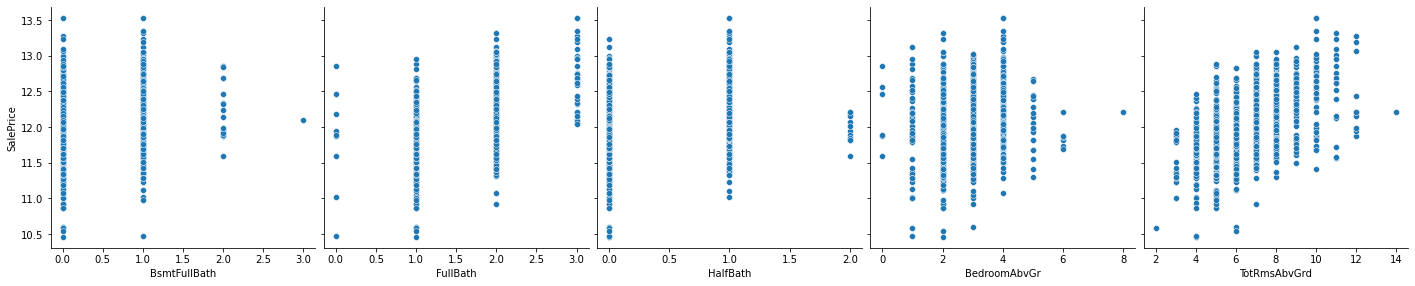

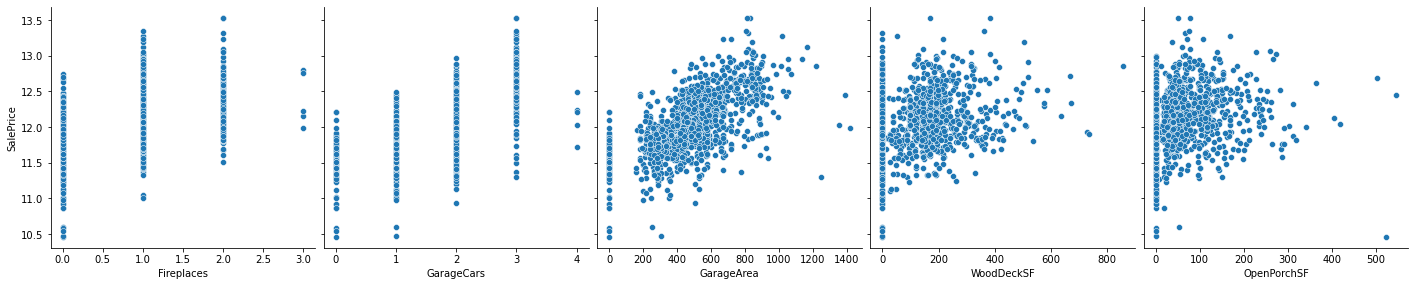

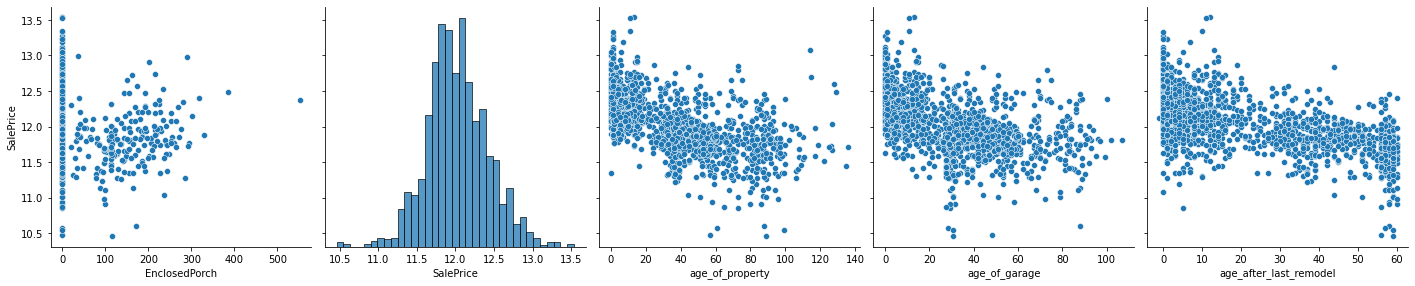

In [49]:
# visualise the data
# Check the numerical values using pairplots

plt.figure(figsize=(10,5))
sns.pairplot(df, x_vars=['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
sns.pairplot(df, x_vars=['EnclosedPorch', 'SalePrice', 'age_of_property', 'age_of_garage','age_after_last_remodel'], y_vars='SalePrice',height=4, aspect=1,kind='scatter')
plt.show()

Observation : 
Linear relationship present between target variable and below variables
1. GrLivArea(living area square feet)
2. 2ndFlrSF (Second floor square feet)
3. 1stFlrSF (First Floor square feet)
4. Garage Area
5. TotalBsmtSF (Total square feet of basement area)
6. Age of property
7. Age of garage
8. Age after remodel


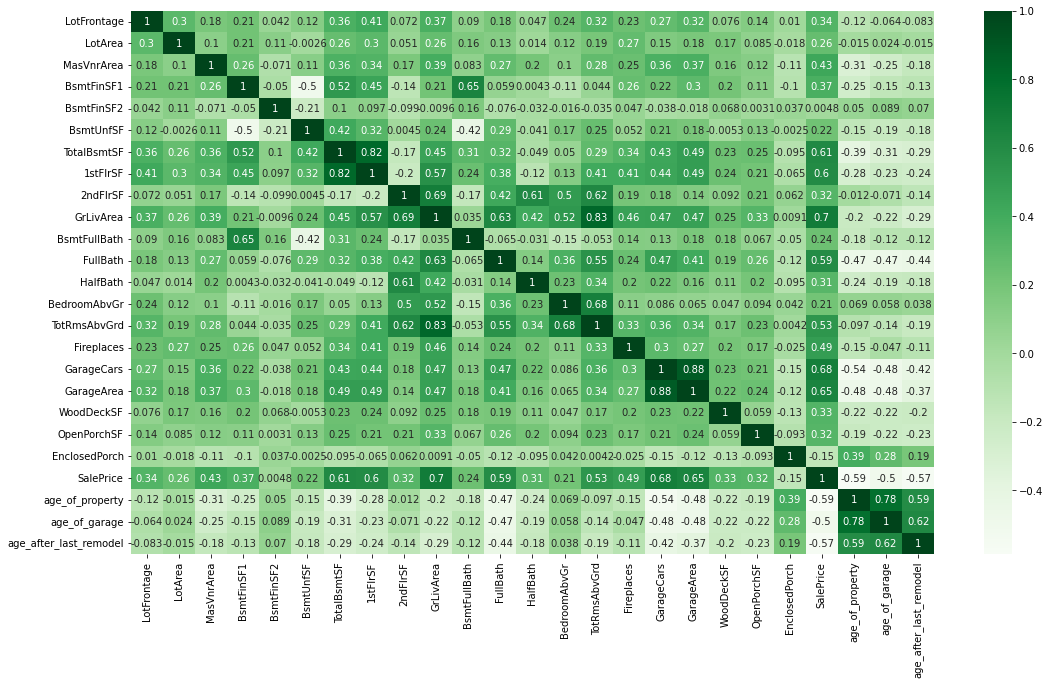

In [50]:
#correlation matrix
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')
plt.show()

Observation:
Correlation observed as target variable and below independent variables
   1. Positive correlation for ground living area
   2. Positive correlation for GarageCars
   3. Positive correlation for GarageArea
   4. Positive correlation for totalBasement surface area
   5. Positive correlation for 1st floor surface area
   6. Positive correlation for Full bath area
   7. Positive correlation for total room area
   8. Negative correlation for age of property, age of garage and age after remodelling

# ModelTraining

## Dummy variables

In [51]:
dummies = pd.get_dummies(catvars,drop_first=True)
print(dummies.shape)

(1460, 157)


In [52]:
dummies.head()

,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_SPLIT OR MULTI-LEVEL,MSSubClass_SPLIT FOYER,MSSubClass_DUPLEX - ALL STYLES AND AGES,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [53]:
# concat with main dataset
df = pd.concat([df, dummies], axis=1) 

In [54]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,2-STORY 1946 & NEWER,RL,65.0,8450,Reg,Inside,CollgCr,2Story,Good,Average,...,0,0,0,0,0,0,0,1,0,0
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600,Reg,FR2,Veenker,1Story,Above Average,Very Good,...,0,0,0,0,0,0,1,0,0,0
2,2-STORY 1946 & NEWER,RL,68.0,11250,IR1,Inside,CollgCr,2Story,Good,Average,...,0,0,1,0,0,0,0,1,0,0
3,2-STORY 1945 & OLDER,RL,60.0,9550,IR1,Corner,Crawfor,2Story,Good,Average,...,0,0,0,0,0,0,0,0,0,0
4,2-STORY 1946 & NEWER,RL,84.0,14260,IR1,FR2,NoRidge,2Story,Very Good,Average,...,0,0,0,0,0,1,0,1,0,0


In [55]:
#remove the category columns as dummy variables have been created.
df.drop(catvars,axis=1,inplace=True)

In [56]:
df.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,65.0,8450,196.0,706,0,150,856,856,854,1710,...,0,0,0,0,0,0,0,1,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,1262,...,0,0,0,0,0,0,1,0,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,1786,...,0,0,1,0,0,0,0,1,0,0
3,60.0,9550,0.0,216,0,540,756,961,756,1717,...,0,0,0,0,0,0,0,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,2198,...,0,0,0,0,0,1,0,1,0,0


## Test train split

In [57]:
df_train,df_test=train_test_split(df,train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(1021, 182)
(439, 182)


## Scaling

In [58]:
scaler = StandardScaler()
df_train[numvars.columns] = scaler.fit_transform(df_train[numvars.columns])

In [59]:
# extract the response variable to y
y_train =df_train.pop('SalePrice')
y_train.head()

318     1.123211
239    -0.978867
986    -0.891115
1416   -0.775233
390    -0.848358
Name: SalePrice, dtype: float64

In [60]:
X_train = df_train
X_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
318,0.925326,-0.057261,0.809137,1.159065,-0.293313,-0.454262,0.621091,0.511410,2.137583,2.121655,...,0,0,0,0,0,0,0,0,1,0
239,-0.795709,-0.169753,-0.558025,-0.761831,-0.293313,0.172244,-0.712611,-0.931882,0.793638,-0.058599,...,0,0,0,0,0,0,0,0,0,1
986,-0.478677,-0.502762,-0.558025,-0.964030,-0.293313,-0.175567,-1.257424,-0.421449,0.667284,0.219811,...,0,0,0,0,0,0,0,0,0,0
1416,-0.433386,0.082504,-0.558025,-0.964030,-0.293313,0.475464,-0.621082,0.194590,1.609195,1.451965,...,0,0,0,0,0,0,0,0,0,1
390,-0.886290,-0.202365,-0.558025,-0.445625,1.996400,-0.746334,-0.438025,-0.522027,0.143490,-0.284338,...,0,0,0,0,0,0,0,1,0,0


In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 318 to 792
Columns: 181 entries, LotFrontage to YrSold_2010
dtypes: float64(24), uint8(157)
memory usage: 356.0 KB


In [62]:
# scale the test data. use only transform in this case.
df_test[numvars.columns] = scaler.transform(df_test[numvars.columns])

In [63]:
# extract the response variable to y
y_test =df_test.pop('SalePrice')
y_test.head()

1436   -0.816759
57      0.416831
780     0.138893
382     0.626143
1170    0.066190
Name: SalePrice, dtype: float64

In [64]:
X_test = df_test
X_test.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1436,-0.433386,-0.144614,-0.558025,0.361022,-0.293313,-0.703973,-0.431488,-0.765928,-0.789230,-1.230557,...,0,0,0,0,0,0,1,0,0,0
57,0.880036,0.112107,-0.558025,-0.964030,-0.293313,0.660517,-0.440205,-0.775986,1.186484,0.379709,...,0,1,0,0,0,0,0,0,0,0
780,-0.297515,-0.253806,-0.355087,-0.964030,-0.293313,1.501060,0.381373,0.212191,-0.789230,-0.498789,...,0,0,0,0,0,0,1,0,0,0
382,0.427132,-0.120835,-0.558025,-0.964030,-0.293313,0.836652,-0.268044,-0.577345,1.181889,0.524557,...,0,0,0,0,0,0,1,0,0,0
1170,0.291260,-0.059203,-0.558025,0.158822,-0.293313,0.022863,0.074099,-0.127259,-0.789230,-0.752744,...,1,0,0,0,0,0,0,1,0,0


## RFE- Recursive Feature Elimination

In [65]:
len(X_train.columns)

181

In [66]:
#Running RFE with 35 features out of 181
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm,n_features_to_select= 35)
rfe = rfe.fit(X_train,y_train)

In [67]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 70),
 ('LotArea', False, 86),
 ('MasVnrArea', False, 146),
 ('BsmtFinSF1', False, 60),
 ('BsmtFinSF2', False, 66),
 ('BsmtUnfSF', False, 67),
 ('TotalBsmtSF', False, 68),
 ('1stFlrSF', False, 75),
 ('2ndFlrSF', False, 74),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 54),
 ('FullBath', False, 145),
 ('HalfBath', False, 121),
 ('BedroomAbvGr', False, 125),
 ('TotRmsAbvGrd', False, 77),
 ('Fireplaces', False, 52),
 ('GarageCars', False, 12),
 ('GarageArea', False, 147),
 ('WoodDeckSF', False, 112),
 ('OpenPorchSF', False, 141),
 ('EnclosedPorch', False, 123),
 ('age_of_property', True, 1),
 ('age_of_garage', False, 129),
 ('age_after_last_remodel', False, 91),
 ('MSSubClass_1-STORY 1945 & OLDER', True, 1),
 ('MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES', False, 9),
 ('MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES', False, 22),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', False, 143),
 ('MSSubClass_2-STORY 1946 & NEWER', False, 34),
 ('MSSubClass_2-STORY 1945

In [68]:
#selected columns from rfe
col = X_train.columns[rfe.support_]
col
X_train_rfe = X_train[col]

#adding a constant variable
X_train_rfe = sm.add_constant(X_train_rfe)

#create a RFE model
lm = sm.OLS(y_train,X_train_rfe).fit()  #Running the linear Model

#Get the Summary of Linear Model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     178.2
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:48   Log-Likelihood:                -444.99
No. Observations:                1021   AIC:                             960.0
Df Residuals:                     986   BIC:                             1132.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
const                                                 -0.9533      0.168     -5.687      0.000      -1.282      -0.624
GrLivArea                                              0.3724      0.016     22.807      0.000       0.340       0.404
age_of_property                                       -0.3075      0.023    -13.480      0.000      -0.352      -0.263
MSSubClass_1-STORY 1945 & OLDER                       -0.3098      0.067     -4.615      0.000      -0.442      -0.178
MSSubClass_2-STORY PUD - 1946 & NEWER                 -0.5972      0.069     -8.625      0.000      -0.733      -0.461
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER    -0.7399      0.163     -4.543      0.000      -1.059      -0.420
MSZoning_FV                                            0.8928      0.197      4.535      0.000       0.506       1.279
MSZoning_RH                                            0.8998      0.187      4.810      0.000       0.533       1.267
MSZoning_RL                                            1.0233      0.158      6.465      0.000       0.713       1.334
MSZoning_RM                                            0.8547      0.160      5.348      0.000       0.541       1.168
Neighborhood_ClearCr                                   0.5145      0.087      5.910      0.000       0.344       0.685
Neighborhood_Crawfor                                   0.4859      0.072      6.729      0.000       0.344       0.628
Neighborhood_NoRidge                                   0.3521      0.076      4.655      0.000       0.204       0.501
Neighborhood_NridgHt                                   0.3326      0.065      5.133      0.000       0.205       0.460
Neighborhood_Somerst                                   0.3781      0.105      3.618      0.000       0.173       0.583
Neighborhood_StoneBr                                   0.2956      0.114      2.595      0.010       0.072       0.519
Neighborhood_Veenker                                   0.3669      0.119      3.086      0.002       0.134       0.600
OverallQual_Poor                                      -1.1867      0.283     -4.197      0.000      -1.742      -0.632
OverallQual_Good                                       0.3036      0.037      8.175      0.000       0.231       0.376
OverallQual_Very Good                                  0.5322      0.054      9.766      0.000       0.425       0.639
OverallQual_Excellent                                  0.8793      0.100      8.812      0.000       0.683       1.075
OverallQual_Very Excellent                             0.5156      0.131      3.922      0.000       0.258       0.774
OverallCond_Good                                       0.2584      0.036      7.121      0.000       0.187  

In [69]:
#check VIF of RFE Model
def calculate_vif(X_train,col):
    vif = pd.DataFrame()
    vif['Features'] = X_train[col].columns
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF',ascending=False)
    return vif

In [70]:
vif = calculate_vif(X_train,col)
vif

,Features,VIF
33,BsmtFinType1_NA,inf
31,BsmtQual_No Basement,inf
7,MSZoning_RL,19.91
32,BsmtQual_TA,13.14
30,BsmtQual_Gd,8.80
5,MSZoning_FV,5.41
8,MSZoning_RM,4.60
13,Neighborhood_Somerst,4.52
1,age_of_property,3.66
18,OverallQual_Very Good,2.48


In [71]:
X_train_rfe.columns

Index(['const', 'GrLivArea', 'age_of_property',
       'MSSubClass_1-STORY 1945 & OLDER',
       'MSSubClass_2-STORY PUD - 1946 & NEWER',
       'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'OverallQual_Poor', 'OverallQual_Good', 'OverallQual_Very Good',
       'OverallQual_Excellent', 'OverallQual_Very Excellent',
       'OverallCond_Good', 'OverallCond_Very Good', 'OverallCond_Excellent',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior2nd_Brk Cmn',
       'ExterQual_Fa', 'Foundation_Stone', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_No Basement', 'BsmtQual_TA', 'BsmtFinType1_NA',
       'HeatingQC_Po'],
      dtype='object')

In [72]:
# drop HeatingQC_Po and retrain
def retrain(x, col,X_train):    
    col=col.drop(x) 
    X_train_rfe = X_train[col]
    #adding a constant variable
    X_train_rfe = sm.add_constant(X_train_rfe)
    #create a RFE model
    lm = sm.OLS(y_train,X_train_rfe).fit()  #Running the linear Model
    #Get the Summary of Linear Model
    print(lm.summary())
    return col
col = retrain('HeatingQC_Po',col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     183.5
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:48   Log-Likelihood:                -445.53
No. Observations:                1021   AIC:                             959.1
Df Residuals:                     987   BIC:                             1127.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [73]:
col = retrain('Foundation_Stone',col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     189.0
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:48   Log-Likelihood:                -446.49
No. Observations:                1021   AIC:                             959.0
Df Residuals:                     988   BIC:                             1122.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [74]:
col = retrain('Neighborhood_StoneBr',col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     193.8
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:48   Log-Likelihood:                -449.95
No. Observations:                1021   AIC:                             963.9
Df Residuals:                     989   BIC:                             1122.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [75]:
col

Index(['GrLivArea', 'age_of_property', 'MSSubClass_1-STORY 1945 & OLDER',
       'MSSubClass_2-STORY PUD - 1946 & NEWER',
       'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_Veenker', 'OverallQual_Poor',
       'OverallQual_Good', 'OverallQual_Very Good', 'OverallQual_Excellent',
       'OverallQual_Very Excellent', 'OverallCond_Good',
       'OverallCond_Very Good', 'OverallCond_Excellent', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior2nd_Brk Cmn', 'ExterQual_Fa',
       'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_No Basement', 'BsmtQual_TA',
       'BsmtFinType1_NA'],
      dtype='object')

In [76]:
col = retrain(['Exterior2nd_Brk Cmn'],col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     199.0
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:48   Log-Likelihood:                -453.20
No. Observations:                1021   AIC:                             968.4
Df Residuals:                     990   BIC:                             1121.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [77]:
vif = calculate_vif(X_train,col)
vif

,Features,VIF
30,BsmtFinType1_NA,inf
28,BsmtQual_No Basement,inf
7,MSZoning_RL,19.87
29,BsmtQual_TA,13.12
27,BsmtQual_Gd,8.80
5,MSZoning_FV,5.39
8,MSZoning_RM,4.58
13,Neighborhood_Somerst,4.46
1,age_of_property,3.64
17,OverallQual_Very Good,2.28


In [78]:
col

Index(['GrLivArea', 'age_of_property', 'MSSubClass_1-STORY 1945 & OLDER',
       'MSSubClass_2-STORY PUD - 1946 & NEWER',
       'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_Veenker', 'OverallQual_Poor',
       'OverallQual_Good', 'OverallQual_Very Good', 'OverallQual_Excellent',
       'OverallQual_Very Excellent', 'OverallCond_Good',
       'OverallCond_Very Good', 'OverallCond_Excellent', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'ExterQual_Fa', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_No Basement', 'BsmtQual_TA', 'BsmtFinType1_NA'],
      dtype='object')

In [79]:
col = retrain(['BsmtFinType1_NA'],col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     199.0
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:49   Log-Likelihood:                -453.20
No. Observations:                1021   AIC:                             968.4
Df Residuals:                     990   BIC:                             1121.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [80]:
vif=calculate_vif(X_train,col)
vif

,Features,VIF
7,MSZoning_RL,19.87
29,BsmtQual_TA,13.12
27,BsmtQual_Gd,8.80
5,MSZoning_FV,5.39
8,MSZoning_RM,4.58
13,Neighborhood_Somerst,4.46
1,age_of_property,3.64
17,OverallQual_Very Good,2.28
16,OverallQual_Good,2.08
26,BsmtQual_Fa,1.91


In [81]:
col

Index(['GrLivArea', 'age_of_property', 'MSSubClass_1-STORY 1945 & OLDER',
       'MSSubClass_2-STORY PUD - 1946 & NEWER',
       'MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_ClearCr',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_Veenker', 'OverallQual_Poor',
       'OverallQual_Good', 'OverallQual_Very Good', 'OverallQual_Excellent',
       'OverallQual_Very Excellent', 'OverallCond_Good',
       'OverallCond_Very Good', 'OverallCond_Excellent', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'ExterQual_Fa', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_No Basement', 'BsmtQual_TA'],
      dtype='object')

In [82]:
col = retrain(['MSZoning_RL'],col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:49   Log-Likelihood:                -474.38
No. Observations:                1021   AIC:                             1009.
Df Residuals:                     991   BIC:                             1157.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [83]:
col = retrain(['MSZoning_RH'],col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     203.3
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:49   Log-Likelihood:                -474.75
No. Observations:                1021   AIC:                             1008.
Df Residuals:                     992   BIC:                             1150.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [84]:
col = retrain(['MSZoning_FV'],col,X_train)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     210.7
Date:                Wed, 02 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:51:49   Log-Likelihood:                -475.42
No. Observations:                1021   AIC:                             1007.
Df Residuals:                     993   BIC:                             1145.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [85]:
vif=calculate_vif(X_train,col)
vif

,Features,VIF
1,age_of_property,3.27
24,BsmtQual_Gd,2.36
14,OverallQual_Very Good,2.10
26,BsmtQual_TA,2.05
13,OverallQual_Good,1.99
0,GrLivArea,1.86
5,MSZoning_RM,1.63
9,Neighborhood_NridgHt,1.58
15,OverallQual_Excellent,1.47
10,Neighborhood_Somerst,1.41


The p values are less than 0.05 and VIF is below 5 for all independent variables.

In [86]:
lm = LinearRegression()
X_train_final=X_train[col]
lm.fit(X_train_final,y_train)
y_train_pred=lm.predict(X_train_final)
print(r2_score(y_train,y_train_pred))

0.8514136095639844


Text(0.5, 0, 'Errors')

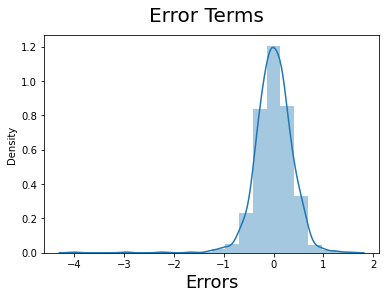

In [87]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

In [88]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_train - y_train_pred))
print(rss)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

151.70670463517197
0.14858639043601565
0.38546905250099606


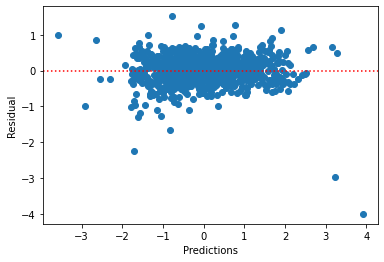

In [89]:
# Residual analysis
y_res = (y_train - y_train_pred)
plt.scatter( y_train_pred , y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

Observation
1. We have an R2 score of 0.851
2. The error terms look normaly distributed and centered around 0
3. No pattern seen in the residual plot
4. mse=0.148
5. rmse=0.385

### Evaluation on test data

The test data has already been scaled along with training data. Refer line number . It was scaled only using transform method alone

In [90]:
y_test_pred=lm.predict(X_test[col])

In [91]:
print(r2_score(y_test,y_test_pred))

0.806893720177701


In [92]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_test - y_test_pred))
print(rss)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

88.91156360043104
0.20253203553628937
0.45003559363264745


Text(0, 0.5, 'y_test_pred')

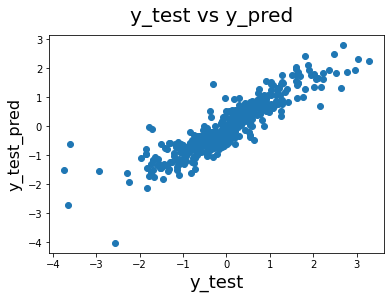

In [93]:
# Plot y_test vs y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20) 
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)

Observation:
    1. The R2score for the test data is 0.806. It is approximately 5% less than the train R2 score
    2. RSS is 88.91156360043104
    3. mse is 0.20253203553628937
    4. rmse is 0.45003559363264745
    
The top independent variables are OverallQual, Exterior1st,BsmtQual,MS_SubClass, ExternalQual

The correlation and coefficients are as mentioned below. - indicates negative correlation

OverallQual_Poor -1.6734
Exterior1st_BrkComm -1.1002
BsmtQual_No Basement -0.9816
OverallQual_Excellent 0.9303
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER -0.7431
ExterQual_Fa -0.7112

The variance seems to be slightly high.
In the next section, lets try to use Regularization to minimize variance without significant increase in bias.

##Model Building and Evaluation using Ridge Regression

In [94]:
# list of alphas to tune
params = {'alpha': [0.000008,0.0001, 0.001, 0.01, 0.1, 10,100,1000]}

rm = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = rm, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [8e-06, 0.0001, 0.001, 0.01, 0.1, 10, 100,
                                   1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [95]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=100]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006801,0.001470,0.003199,0.001166,0.000008,{'alpha': 8e-06},0.855649,0.775270,0.820863,0.853733,...,0.841416,0.041880,6,0.927551,0.938083,0.935267,0.924949,0.919111,0.928992,0.006900
1,0.007800,0.001469,0.003400,0.000800,0.0001,{'alpha': 0.0001},0.855650,0.775274,0.820870,0.853745,...,0.841421,0.041879,5,0.927551,0.938083,0.935267,0.924949,0.919111,0.928992,0.006900
2,0.006402,0.001496,0.002597,0.000801,0.001,{'alpha': 0.001},0.855662,0.775306,0.820938,0.853856,...,0.841472,0.041879,4,0.927551,0.938083,0.935266,0.924949,0.919111,0.928992,0.006900
3,0.005400,0.000491,0.002400,0.000491,0.01,{'alpha': 0.01},0.855803,0.775542,0.821566,0.854918,...,0.841946,0.041905,3,0.927549,0.938073,0.935259,0.924947,0.919108,0.928987,0.006898
4,0.005601,0.000801,0.002400,0.000493,0.1,{'alpha': 0.1},0.857963,0.775201,0.825009,0.862650,...,0.845060,0.043102,2,0.927427,0.937759,0.934894,0.924802,0.918905,0.928757,0.006829


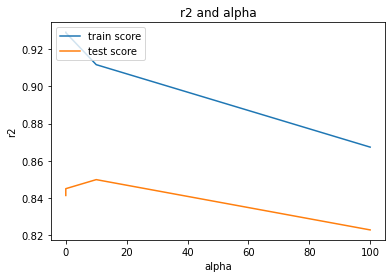

In [96]:
# plotting mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [97]:
#optimum alpha
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-1.97566929e-02,  4.35498044e-02,  1.55188119e-02, -5.59349769e-03,
        6.87560777e-03,  2.97450978e-02,  2.59658072e-02,  9.14306468e-02,
        1.09647808e-01,  1.23670896e-01,  6.04402151e-02,  7.12057398e-02,
        4.66586503e-02,  2.03883456e-02,  3.09349957e-02,  7.39610659e-02,
        1.04484345e-01,  1.42719138e-02,  3.27120278e-02, -1.92910238e-03,
        1.65517137e-02, -1.45583638e-01,  1.27475382e-03, -7.85018830e-02,
       -2.24486758e-01, -1.51379800e-02, -5.83944167e-03,  6.01049725e-02,
       -2.49589122e-02,  1.65415425e-01,  9.61540297e-02, -6.54518673e-03,
        1.05828343e-02, -1.26126314e-01, -1.06117246e-01, -2.40123588e-01,
       -1.13454681e-01, -7.37449580e-02,  1.64855972e-01,  1.12334323e-01,
        1.96302339e-01,  4.46832401e-02,  5.31969386e-02, -1.38925722e-01,
        2.36209006e-02,  1.20205597e-01, -6.89533621e-02, -3.13964013e-02,
        4.70667920e-03, -1.06171193e-02, -7.37144270e-02,  6.31456626e-02,
        1.20432801e-01, -

### Analysis of train data

In [98]:
y_train_pred=ridge.predict(X_train)

In [99]:
print(r2_score(y_train,y_train_pred))

0.9085464561765176


Text(0.5, 0, 'Errors')

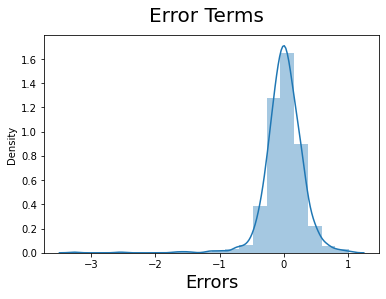

In [100]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

In [101]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_train - y_train_pred))
print(rss)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

93.37406824377553
0.09145354382348239
0.30241286980464704


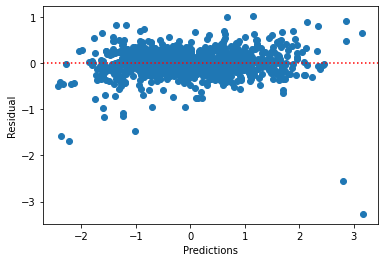

In [102]:
# Residual analysis
y_res = (y_train - y_train_pred)
plt.scatter( y_train_pred , y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

Observation
1. We have an R2 score of 0.90 which is an improvement over 0.851
2. The error terms look normaly distributed and centered around 0
3. No pattern seen in the residual plot
4. mse = 0.091 which is lower than 0.148
5. rmse =0.302 which is lower than 0.385

### Evaluate the test data

In [103]:
y_test_pred=ridge.predict(X_test)

In [104]:
print(r2_score(y_test,y_test_pred))

0.8734796241233447


In [105]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_test - y_test_pred))
print(rss)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

58.25354026217785
0.13269599148559874
0.3642746099930638


Text(0, 0.5, 'y_test_pred')

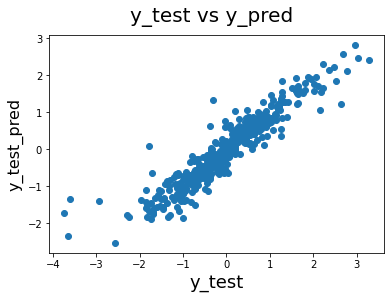

In [106]:
# Plot y_test vs y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20) 
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)

Observation:
   1. The R2score for the test data is 0.873. It is an improvement over 0.806 we had received without regularization
   2. RSS is 58.25
   3. mse is 0.132 which is lesser than 0.202
   4. rmse is 0.364 which is lesser than 0.450

In [107]:
# Ridge model parameters
model_parameters = list(sorted(ridge.coef_))
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = df_train.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 0.015),
 ('LotFrontage', -0.301),
 ('LotArea', -0.24),
 ('MasVnrArea', -0.224),
 ('BsmtFinSF1', -0.212),
 ('BsmtFinSF2', -0.211),
 ('BsmtUnfSF', -0.177),
 ('TotalBsmtSF', -0.169),
 ('1stFlrSF', -0.168),
 ('2ndFlrSF', -0.167),
 ('GrLivArea', -0.162),
 ('BsmtFullBath', -0.153),
 ('FullBath', -0.146),
 ('HalfBath', -0.146),
 ('BedroomAbvGr', -0.139),
 ('TotRmsAbvGrd', -0.139),
 ('Fireplaces', -0.139),
 ('GarageCars', -0.138),
 ('GarageArea', -0.129),
 ('WoodDeckSF', -0.127),
 ('OpenPorchSF', -0.126),
 ('EnclosedPorch', -0.126),
 ('age_of_property', -0.115),
 ('age_of_garage', -0.114),
 ('age_after_last_remodel', -0.113),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.107),
 ('MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES', -0.106),
 ('MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES', -0.102),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.102),
 ('MSSubClass_2-STORY 1946 & NEWER', -0.094),
 ('MSSubClass_2-STORY 1945 & OLDER', -0.092),
 ('MSSubClass_2-1/2 STORY ALL AGES', -0.09),
 ('M

The top independent variables are

YrSold
LotFrontage
LotArea
MasVnrArea
BsmtFinSF
MoSold
GrLivArea


The correlation and coefficients are as tabled above. - indicates negative correlation


## Model Building and Evaluation using Lasso Regression

In [108]:
params = {'alpha': [0.00006,0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008 ]}
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [6e-05, 0.0006, 0.0008, 0.001, 0.002, 0.004,
                                   0.006, 0.008]},
             return_train_score=True, scoring='r2', verbose=1)

In [109]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.124255,0.030847,0.002000,0.001789,0.00006,{'alpha': 6e-05},0.858415,0.774688,0.826076,0.862182,...,0.845358,0.043424,5,0.927326,0.937550,0.934691,0.924769,0.918697,0.928607,0.006805
1,0.052599,0.011942,0.002800,0.000748,0.0006,{'alpha': 0.0006},0.883595,0.756401,0.822481,0.892454,...,0.853317,0.056913,1,0.921802,0.932250,0.928304,0.918275,0.912372,0.922601,0.007066
2,0.042698,0.017607,0.002403,0.001357,0.0008,{'alpha': 0.0008},0.888484,0.750492,0.816506,0.895251,...,0.852417,0.060477,2,0.919075,0.930398,0.925892,0.915606,0.909921,0.920178,0.007272
3,0.038959,0.009692,0.001000,0.002000,0.001,{'alpha': 0.001},0.890322,0.744623,0.818014,0.894440,...,0.851918,0.062573,3,0.916479,0.928356,0.924421,0.913064,0.907822,0.918028,0.007466
4,0.037498,0.007655,0.000000,0.000000,0.002,{'alpha': 0.002},0.892601,0.721394,0.820540,0.894110,...,0.847550,0.070187,4,0.904513,0.918493,0.915800,0.903682,0.895946,0.907687,0.008325


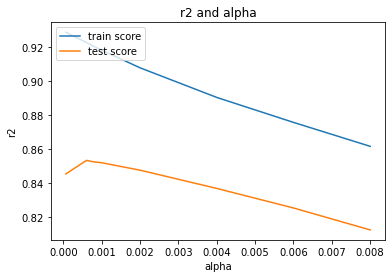

In [110]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')

plt.title("r2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [111]:
#optimum alpha

alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.001)

In [112]:
lasso.coef_

array([-0.02314834,  0.04233727,  0.00769867, -0.        ,  0.00427553,
        0.03520617,  0.01314959,  0.04377005,  0.06342539,  0.19102401,
        0.06174826,  0.06802003,  0.0458785 ,  0.0147854 ,  0.02308334,
        0.06555198,  0.10848629,  0.        ,  0.03091194, -0.00083921,
        0.01538888, -0.14520049, -0.        , -0.07170562, -0.28005988,
       -0.        , -0.        ,  0.03796483, -0.01802945,  0.10535927,
        0.04696341, -0.        ,  0.        , -0.13700216, -0.12807387,
       -0.32851948, -0.13359842, -0.06075616,  0.24328514,  0.20831631,
        0.26174078,  0.11312724,  0.04040023, -0.12445955,  0.02625642,
        0.11057564, -0.05160755, -0.        ,  0.        , -0.        ,
       -0.        ,  0.07146454,  0.17858969,  0.01707096,  0.33988289,
       -0.1874219 ,  0.        , -0.12233466, -0.21350492, -0.00207686,
       -0.00548918, -0.        , -0.00769039,  0.24203508,  0.27766355,
       -0.06237458,  0.        , -0.07342125,  0.        ,  0.25

### Analysis of train data

In [113]:
y_train_pred=lasso.predict(X_train)

In [114]:
print(r2_score(y_train,y_train_pred))

0.9126013659929145


Text(0.5, 0, 'Errors')

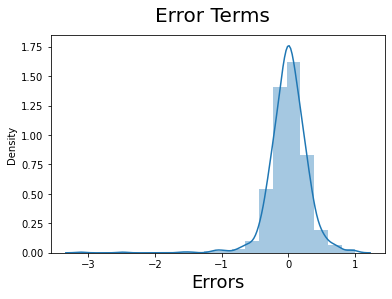

In [115]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

In [116]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_train - y_train_pred))
print(rss)
mse = mean_squared_error(y_train, y_train_pred)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

89.23400532123422
0.08739863400708543
0.29563259970288364


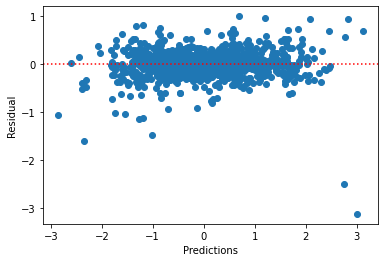

In [117]:
# Residual analysis
y_res = (y_train - y_train_pred)
plt.scatter( y_train_pred , y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

# Observation
1. We have an R2 score of 0.91 which is an improvement over 0.851 without regularization
2. The error terms look normaly distributed and centered around 0
3. No pattern seen in the residual plot
4. mse = 0.087 which is better than ridge regression 0.091 and better than 0.148 without regularization
5. rmse = 0.295 which is better than ridge regression 0.302 which is better than 0.385 without regularization

### Evaluate the test data

In [118]:
y_test_pred=lasso.predict(X_test)

In [119]:
print(r2_score(y_test,y_test_pred))

0.8782408193804506


In [120]:
#Residual Sum of Squares = Mean_Squared_Error * Total number of datapoints
rss = np.sum(np.square(y_test - y_test_pred))
print(rss)
mse = mean_squared_error(y_test, y_test_pred)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

56.061352026218884
0.1277023964150772
0.357354720711896


Text(0, 0.5, 'y_test_pred')

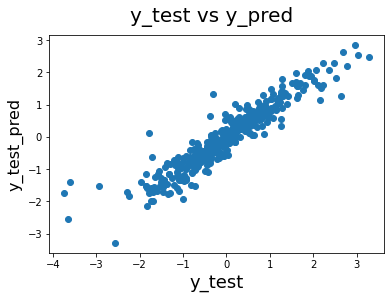

In [121]:
# Plot y_test vs y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20) 
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)

Observation:
    1. The R2score for the test data is 0.878. It is an improvement over 0.806 we had received without regularization
    2. RSS is56.061
    3. mse is 0.127 which is better than 0.132 which is better than 0.202 without regularization
    4. rmse is 0.357 which is better than 0.364 which is better than 0.450 without regularization

In [122]:
# lasso model parameters
model_parameters = list(sorted(lasso.coef_))
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = df_train.columns
cols = cols.insert(0, "constant")
list((zip(cols, model_parameters)))

[('constant', -0.041),
 ('LotFrontage', -0.748),
 ('LotArea', -0.481),
 ('MasVnrArea', -0.338),
 ('BsmtFinSF1', -0.329),
 ('BsmtFinSF2', -0.322),
 ('BsmtUnfSF', -0.28),
 ('TotalBsmtSF', -0.216),
 ('1stFlrSF', -0.214),
 ('2ndFlrSF', -0.187),
 ('GrLivArea', -0.162),
 ('BsmtFullBath', -0.158),
 ('FullBath', -0.145),
 ('HalfBath', -0.137),
 ('BedroomAbvGr', -0.137),
 ('TotRmsAbvGrd', -0.136),
 ('Fireplaces', -0.134),
 ('GarageCars', -0.128),
 ('GarageArea', -0.124),
 ('WoodDeckSF', -0.123),
 ('OpenPorchSF', -0.122),
 ('EnclosedPorch', -0.12),
 ('age_of_property', -0.115),
 ('age_of_garage', -0.114),
 ('age_after_last_remodel', -0.112),
 ('MSSubClass_1-STORY 1945 & OLDER', -0.098),
 ('MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES', -0.09),
 ('MSSubClass_1-1/2 STORY - UNFINISHED ALL AGES', -0.09),
 ('MSSubClass_1-1/2 STORY FINISHED ALL AGES', -0.089),
 ('MSSubClass_2-STORY 1946 & NEWER', -0.08),
 ('MSSubClass_2-STORY 1945 & OLDER', -0.073),
 ('MSSubClass_2-1/2 STORY ALL AGES', -0.072),
 ('MSS

The top independent variables are

LotFrontage
YrSold
LotArea
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
MoSold
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea

The correlation and coefficients are as tabled above. - indicates negative correlation


# Summary

- R2 scores are as below
- Ridge                     Train :0.908   Test :0.873
- Lasso                     Train :0.912   Test :0.878
- Without Regularization :  Train :0.851   Test :0.806

Significant variables for Ridge regression:YrSold LotFrontage LotArea MasVnrArea BsmtFinSF MoSold GrLivArea

Significant variables for Lasso regression: LotFrontage
YrSold
LotArea
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
MoSold
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea

- Regularization parameter lambda for ridge : 10
- Regularization parameter lambda for Lasso : 0.001

Lasso regression gives a better model.

 



 